In [96]:
import os
import json
import numpy as np
from quinine import QuinineArgumentParser
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import copy
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm.notebook import tqdm


In [130]:
result_dir = '../results2/model_probe/'


# this is for two L=20 models, both trained to full 500k, and probe_model trained for 100k
result_name = {
    'grad':{
        'unloop': '0901115634_unloop_lr=0.001_target=grad_control=False_b5b6_diff_mlp_relu_L20_largeBatch',
        'loop': '0831002516_loop_lr=0.001_target=grad_control=False_1ef6_diff_mlp_relu_L12_largeBatch'
    },
    'Wols':{
        'unloop': '0901115634_unloop_lr=0.001_target=Wols_control=False_cbcf_diff_mlp_relu_L20_largeBatch',
        'loop': '0831002516_loop_lr=0.001_target=Wols_control=False_bb76_diff_mlp_relu_L12_largeBatch'
    }
}

control_result_name = {
    'grad':{
        'unloop': '0905121331_unloop_lr=0.001_target=grad_control=True_7cd7_diff_mlp_relu_L20_largeBatch',
        'loop': '0907122856_loop_lr=0.001_target=grad_control=True_0dd6_diff_mlp_relu_L20_largeBatch'
    },
    'Wols':{
        'unloop': '0904164926_unloop_lr=0.001_target=Wols_control=True_5c8b_diff_mlp_relu_L20_largeBatch',
        'loop': '0904214357_loop_lr=0.001_target=Wols_control=True_f259_diff_mlp_relu_L20_largeBatch'
    }
}


In [131]:
fig_hparam = {
    'figsize': (8, 3),
    'labelsize': 28,
    'ticksize': 20,
    'linewidth': 5,
    'fontsize': 15,
    'titlesize': 20,
    'markersize': 15
}

# font specification
fontdict = {'family': 'serif',
         'size': fig_hparam['fontsize'],
         }

unloop_color = '#3b4cc0'
loop_color = '#b40426'

grad unloop
tensor([0.5856, 0.6121, 0.5604, 0.5391, 0.4776, 0.4493, 0.4478, 0.4292, 0.4306,
        0.4308, 0.4307, 0.4579, 0.5086, 0.5442, 0.5725, 0.5997, 0.6073, 0.6138,
        0.6210, 0.6168, 0.6191])
grad loop
tensor([0.5814, 0.5650, 0.5521, 0.5382, 0.5143, 0.4899, 0.4941, 0.4675, 0.4491,
        0.4285, 0.4211, 0.4097, 0.3866, 0.3980, 0.3836, 0.3773, 0.3666, 0.3675,
        0.3634, 0.3614, 0.3596])
Wols unloop
tensor([0.4932, 0.5223, 0.4830, 0.4717, 0.4308, 0.4001, 0.3756, 0.3610, 0.3526,
        0.3428, 0.3363, 0.3691, 0.4076, 0.4460, 0.4782, 0.4953, 0.5201, 0.5266,
        0.5218, 0.5166, 0.5223])
Wols loop
tensor([0.4966, 0.4779, 0.4782, 0.4689, 0.4500, 0.4424, 0.4327, 0.4177, 0.3838,
        0.3495, 0.3358, 0.3343, 0.3203, 0.3217, 0.3106, 0.3176, 0.3013, 0.3106,
        0.3036, 0.3009, 0.2983])


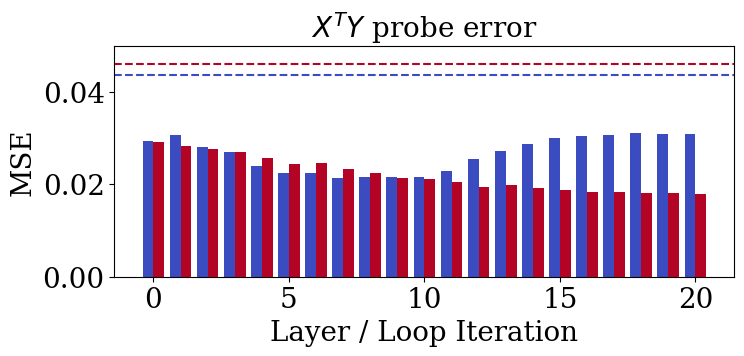

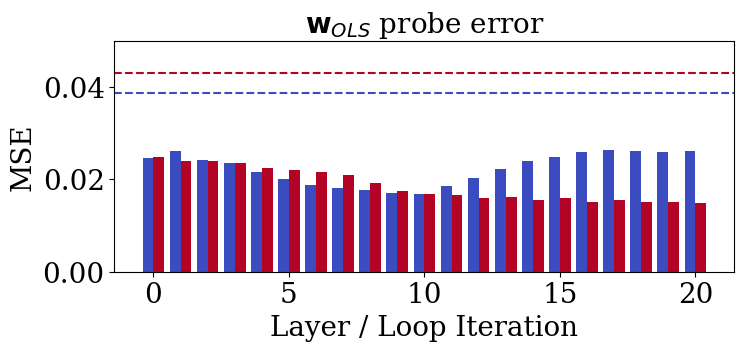

In [157]:
for target_mode in result_name.keys():
    fig, ax = plt.subplots(1, figsize=fig_hparam['figsize'])
    for loop_mode in result_name[target_mode]:
        print(target_mode, loop_mode)
        if loop_mode == 'unloop':
            offset = -0.2
            n_points = 21
            color = unloop_color
            label = 'Transformer'
        else:
            offset = 0.2
            n_points = 21
            color = loop_color
            label = 'Looped Transformer'
        filename = result_name[target_mode][loop_mode]
        tmp = torch.load(result_dir + filename + '/state_dict.pt', map_location=torch.device('cpu'))
        print(tmp['p_loss'])

        plt.rc('font', family='serif')
        ax.bar(np.arange(n_points) + offset, tmp['p_loss'] / 20, 0.4, label=label, color=color)
        
        # load the control=True results
        filename = control_result_name[target_mode][loop_mode]
        tmp = torch.load(result_dir + filename + '/state_dict.pt', map_location=torch.device('cpu'))
#         print(tmp['p_loss'])
        ax.axhline(tmp['p_loss'].min() / 20, color=color, ls='--')

    plt.ylim([0, 0.05])
    plt.xlabel('Layer / Loop Iteration', fontsize=20)
    plt.ylabel('MSE', fontsize=20)
    plt.tick_params(axis='both', labelsize=fig_hparam['ticksize'])
    if target_mode == 'grad':
        plt.title(r"$X^TY$ probe error", fontsize=20)
    else:
        plt.title(r"$\mathbf{w}_{OLS}$ probe error", fontsize=20)
    plt.savefig("result_folder/Figures/model_probe_{}.pdf".format(target_mode), format='pdf', dpi=600, bbox_inches='tight')
    
#     plt.show()

# Only plot the legend

grad unloop
tensor([0.5856, 0.6121, 0.5604, 0.5391, 0.4776, 0.4493, 0.4478, 0.4292, 0.4306,
        0.4308, 0.4307, 0.4579, 0.5086, 0.5442, 0.5725, 0.5997, 0.6073, 0.6138,
        0.6210, 0.6168, 0.6191])
grad loop
tensor([0.5814, 0.5650, 0.5521, 0.5382, 0.5143, 0.4899, 0.4941, 0.4675, 0.4491,
        0.4285, 0.4211, 0.4097, 0.3866, 0.3980, 0.3836, 0.3773, 0.3666, 0.3675,
        0.3634, 0.3614, 0.3596])
Wols unloop
tensor([0.4932, 0.5223, 0.4830, 0.4717, 0.4308, 0.4001, 0.3756, 0.3610, 0.3526,
        0.3428, 0.3363, 0.3691, 0.4076, 0.4460, 0.4782, 0.4953, 0.5201, 0.5266,
        0.5218, 0.5166, 0.5223])
Wols loop
tensor([0.4966, 0.4779, 0.4782, 0.4689, 0.4500, 0.4424, 0.4327, 0.4177, 0.3838,
        0.3495, 0.3358, 0.3343, 0.3203, 0.3217, 0.3106, 0.3176, 0.3013, 0.3106,
        0.3036, 0.3009, 0.2983])


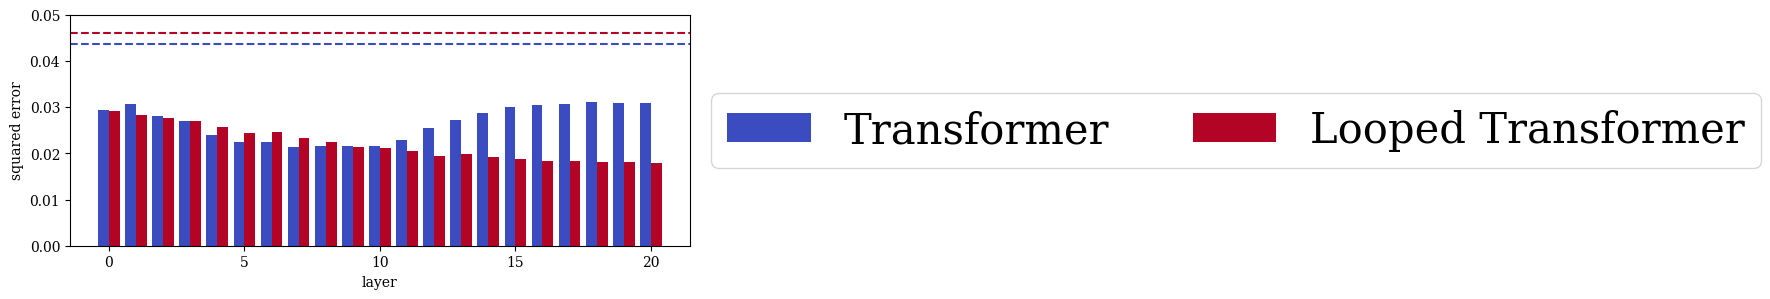

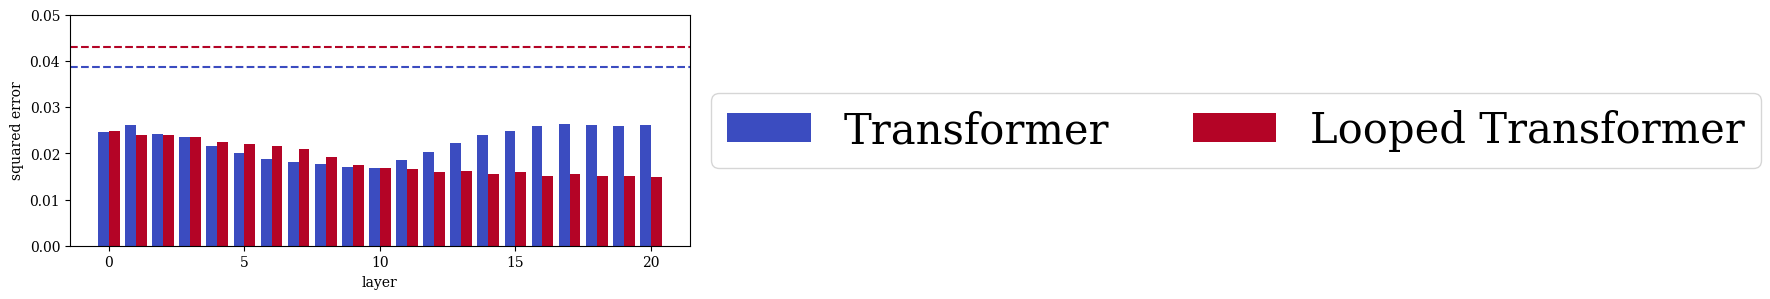

In [147]:
for target_mode in result_name.keys():
    fig, ax = plt.subplots(1, figsize=fig_hparam['figsize'])
    for loop_mode in result_name[target_mode]:
        print(target_mode, loop_mode)
        if loop_mode == 'unloop':
            offset = -0.2
            n_points = 21
            color = unloop_color
            label = 'Transformer'
        else:
            offset = 0.2
            n_points = 21
            color = loop_color
            label = 'Looped Transformer'
        filename = result_name[target_mode][loop_mode]
        tmp = torch.load(result_dir + filename + '/state_dict.pt', map_location=torch.device('cpu'))
        print(tmp['p_loss'])

        plt.rc('font', family='serif')
        ax.bar(np.arange(n_points) + offset, tmp['p_loss'] / 20, 0.4, label=label, color=color)
        
        # load the control=True results
        filename = control_result_name[target_mode][loop_mode]
        tmp = torch.load(result_dir + filename + '/state_dict.pt', map_location=torch.device('cpu'))
#         print(tmp['p_loss'])
        ax.axhline(tmp['p_loss'].min() / 20, color=color, ls='--')
    

    plt.ylim([0, 0.05])
    plt.xlabel('layer')
    plt.ylabel('squared error')
    legend = plt.legend(ncol=2, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=30, )
    plt.savefig("result_folder/Figures/model_probe_legend.pdf", format='pdf', dpi=600, bbox_inches='tight')
    
#     plt.show()